## Import required libaries

In [2]:
! pip install camel_tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1

In [3]:
! pip install pyarabic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.cm as cm
import random

import scipy.sparse
import re
import string
import pyarabic.araby as araby
import nltk
from nltk.corpus import stopwords
import textblob
from textblob import Word
from sklearn import preprocessing

from wordcloud import WordCloud
import camel_tools
import warnings
from camel_tools.utils.dediac import dediac_safebw
from camel_tools.utils.charmap import CharMapper
from camel_tools.utils.transliterate import Transliterator
from sklearn.feature_extraction.text import TfidfVectorizer

## Defining Functions for Pre-processing

In [46]:
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [47]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', string)

In [48]:
def has_diacritics(text):
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    stripped_text = araby.strip_diacritics(text)
    stripped_text = araby.strip_shadda(stripped_text)
    stripped_text = araby.strip_tashkeel(stripped_text)
    if stripped_text != text:
      return 1
    else :
      return 0

In [50]:
def remove_diacritics(text):
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', text)
    text = araby.strip_diacritics(text)
    text = araby.strip_shadda(text)
    text = araby.strip_tashkeel(text)
    return text

The presence of Latin characters will mess with transliteration later on.

so, we should remove them.
also, remove linsk (https), Hashtages and digits.

In [51]:
def remove_non_arabic(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = re.sub('([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    return text

In [52]:
def remove_repeating_characters(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    #text = re.sub(r'(.)\1+', r'\1', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    return text

## Read Data

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
data = pd.read_csv('/content/drive/MyDrive/ITI/Data.csv', encoding='utf-8',lineterminator='\n')

In [55]:
data['text'] = data['text'].astype(str)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147725 entries, 0 to 147724
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      147725 non-null  object
  147725 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [57]:
data.shape

(147725, 2)

In [58]:
data.head(20)

,text,dialect\r
0,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو اختهم او قريبتهم تتعاكس تقولي عليهم من نشاط حقوق المرأة من ردة فعلهم.,LY\r
1,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ليا انا ميليشياوي زمان وتوة,LY\r
2,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بيرتاح لبنت مختلفة ويلاحظ انها غير كل البنات وبيحس كأنه يعرفها من زمان. بعدين يتزوج وحدة منهن وممكن اثنين ولاثلاثة وتنقلب الرومانسية لعياط وشياط وتهزيب\nand they live happily ever after\nذي اند,LY\r
3,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا الانسان يلي يحتاج اهل يخاف منهم علشان يكون محترم هو انسان قليل الادب اصلاً. ثانياً شن ذنب يلي معندهش اب ولا ام ولا خوت ولا خوات؟ يعني اليتيمة متستحقش تتزوج؟ وثالثاً ليش البنت هي بس لازم ادير الف حساب للراجل؟ هي متستحقش يندارلها الف حساب ولا هي عبدة؟,LY\r
4,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ازوج بنت يتيمة ولا بنت معندهش خوت. هدي اعصابك وفكينا من التخلف امتاعك,LY\r
5,@alibobkr63 او حتى من اي دين او طائفة. اسف ممكن الغلط غلطتي بس مكنش قصدي,LY\r
6,@muhamed01111 باهي نستنوه. بلكي مشغول ولا حاجة,LY\r
7,@muhamed01111 مهما اختلفنا راه نحنا خوت. والله ما عندي عدا على واحد. انا فرحان نقدر انروح لحوشنا وفرحان للناس الاخرى الفرحانة. ربي يفرجها عليك وعلينا كلنا,LY\r
8,@muhamed01111 بالنسبة ليا انا والله شبعت هم ونكد وقتل ودم والحقد. الله يهدينا جميعا,LY\r
9,@Ajo32asLibya @Jed_ly مو نحنا الحياة عندنا مية في مية ومعندش شي اندكوا راسنا فيه الا لبس الشورتات.\nتخلف,LY\r


In [59]:
pd.set_option('display.max_colwidth', None)
data.sample(50)

,text,dialect\r
107309,@NinaaKar خلص سنانك حلوين ما تعملي شي,LB\r
7062,كلماته في الصميم و عنده حق و حسبي الله و نعم الوكيل في كل ما كان عنده يد في اللي صار و قاعد ايصير نشهد بالله انها عنصرية و عدم انسانية ، وًخاطري نفهم كيف هالوليد شنو الذنب اللي داره بيش يتهجر هذا ممكن في ايام المجيدة كان عمره سنه او ثنين #تاورغاء #ليبيا https://t.co/xuXE27PuGY,LY\r
93291,شكلي وانا قدام الكشير بدفع فلوس 😂😂 https://t.co/0sU7QkdVHY,EG\r
77437,@3mrShokry انتوا احسن من تشيلسي و احنا اخطر منكم قدام و توتنهام قوي فشخ.. بس حاسس ان الليفر هيركز على اللقب و السيتي هيركز في اوروبا.. علشان كده شايفه منطقي التوقع ده,EG\r
7993,بس شي غريب الأمم المتحدة مشعرتش بالقلق على معيتيقة وإلا شعرت غير انا مكنتش موجود؟,LY\r
144865,@Koz_Moo 🤔ما افتكر براهو يبقى بي جازو,SD\r
124551,#المنيح_ب_هالايام بيتاكل راسو 🙂,LB\r
77446,صحيت لقيت مجدي بس اللي مكلمني و لسبب ماينفعش نقوله هنا .. أتمناه عيد هادي و ساكت علشان انا اساسا على أخري، نهاركم رايق,EG\r
15905,@batmanah600 @abusallah2016 @anwarmalek ميزانيتكم استنزفتها ايفانكا وأبوها,LY\r
31392,من وقت لتاني عرف الناس اللي بتحبها انك بتحبهم و انا الحياه من غيرهم ملهاش طعم 💖...,LY\r


In [60]:
data.columns

Index(['text', 'dialect\r'], dtype='object')

In [61]:
data['dialect\r'].value_counts()

dialect\r
EG\r    57636
LY\r    36499
LB\r    27617
SD\r    14434
MA\r    11539
Name: count, dtype: int64

## Text Pre-processing

- **Removing Punctuations and Symbols**

In [19]:
english_punctuations = string.punctuation
english_punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
punctuations_list = arabic_punctuations + english_punctuations
punctuations_list

'`÷×؛<>_()*&^%][ـ،/:"؟.,\'{}~¦+|!”…“–ـ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [62]:
data['text'] = data['text'].apply(remove_punctuations)

- **Remove Emojis**

In [63]:
data['text'] = data['text'].apply(remove_emoji)

- **Stop Words Elimination**

In [23]:
nltk.download('stopwords')
stop=stopwords.words('arabic')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [64]:
stop

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [65]:
data['text'] = data['text'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))

- **Remove Diacritics**

In [66]:
data['has_diacritics'] = data['text'].apply(has_diacritics)

In [68]:
data.groupby('dialect\r')['has_diacritics'].value_counts()

dialect\r  has_diacritics
EG\r       0                 54692
           1                  2944
LB\r       0                 24770
           1                  2847
LY\r       0                 35249
           1                  1250
MA\r       0                 11452
           1                    87
SD\r       0                 13857
           1                   577
Name: count, dtype: int64

In [69]:
data['text'] = data['text'].apply(remove_diacritics)

- **Remove Non-Arabic Characters**

In [70]:
data['text'] = data['text'].apply(remove_non_arabic)

- **Remove Repeated Characters**

In [71]:
data['text'] = data['text'].apply(remove_repeating_characters)

- **Lemmatisation**

In [72]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [73]:
data['text'] = data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

- **Encoding the Target Classes**

In [74]:
# Create a dictionary to map the labels to their encoded values
label_map = {'EG\r': 0, 'LY\r': 2, 'LB\r': 1, 'SD\r': 4, 'MA\r': 3}

# Create a new column with the encoded labels
data['dialect\r']=data['dialect\r'].map(label_map)

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147725 entries, 0 to 147724
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            147725 non-null  object
        147725 non-null  int64 
 2   has_diacritics  147725 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [76]:
data['dialect\r'].value_counts()

dialect\r
0    57636
2    36499
1    27617
4    14434
3    11539
Name: count, dtype: int64

In [77]:
data.dropna()

,text,dialect\r,has_diacritics
0,قليلين ادب ومنافقين اختهم او قريبتهم تتعاكس تقولي عليهم نشاط حقوق المراه رده فعلهم,2,0
1,الليبيين متقلبين بالنسبه ليا انا ميليشياوي زمان وتوه,2,0
2,تانيه شاب ليبي بيرتاح لبنت مختلفه ويلاحظ انها البنات وبيحس كانه يعرفها زمان بعدين يتزوج وحده منهن وممكن ولاثلاثه وتنقلب الرومانسيه لعياط وشياط وتهزيب اند,2,0
3,رانيا عقليتك متخلفه اولا الانسان يلي يحتاج اهل يخاف منهم علشان يكون محترم انسان قليل الادب اصلا ثانيا شن ذنب يلي معندهش اب ام خوت خوات يعني اليتيمه متستحقش تتزوج وثالثا ليش البنت لازم ادير الف حساب للراجل متستحقش يندارلها الف حساب عبده,2,1
4,شكلك متعقده علشان الراجل تحبيه ازوج بنت يتيمه بنت معندهش خوت هدي اعصابك وفكينا التخلف امتاعك,2,0
...,...,...,...
147720,الناس دي بتنفخ قربه مقدوده بالدارجي كده البلد دي الكيزان ديل راحو مافي حياه شريفه البلد دي لان سبب الفساد والمصاءب الموجوده التطلعلسودانافضل,4,0
147721,انت عايش وين بره السودان شنو ماشايف البحصل دا,4,0
147722,مااحرم نفسي ميسي حريف ولعاب برضو مدريدي وافتخر,4,0
147723,ياخي ديل ماخلو للشيطان وابليس شي يروحو وين ربنا ونحن وراك وراك ياكوز ياعفن الايام معدوده خلاص تعرفعليالكيزان,4,0


## Saving pre-processed data

In [78]:
data = data.sample(frac=1)

In [79]:
data.to_csv('/content/drive/MyDrive/ITI/preprocessed_data2.csv')

In [80]:
data_cleaned = pd.read_csv('/content/drive/MyDrive/ITI/preprocessed_data2.csv', lineterminator='\n')

In [81]:
pd.set_option('display.max_colwidth', None)
data_cleaned.sample(50)


,Unnamed: 0,text,dialect\r,has_diacritics
115293,98163,ايه انا شايف التايم لاين شكوي دكاتره الاسنان ركزوا شويه زملامش كده يعني,0,0
140457,92019,شد حيلك كهربا جمهور الزمالك بيحبك وانت نجم الفريق والناس بتبقي مستنيه منك كتير واوعا تزعل جمهور الزمالك لان احنا عارفين انك عندك اكتر كده مره,0,0
33345,71781,افتكرتهبعمله لولادي علي طول بقول بيض اسكتلندي,0,0
128951,145340,باقي ايام رفع الحظر وامريكا المشيه والجيه تبقي لينا زي السوق العربي,4,0
76559,56083,طب السباق ده استراليا حيجيب مشاكل برضه,0,0
83072,117034,يلي بخوف هوي سجله الهدفين شفنا رده فعل الا بتسديده ماتيتش اخر الشوط الاول وحتي سجلنا شفت رده فعل قويه,1,0
59834,4345,المخلوق المليشياوي القذر يمشي حياته خنبه تلخبيط سيارات عاهرات سفرات مجرد مايموت يحولوه اهله ناسه مدينته لراجل محترم يصلي الفجر حاضر عنده زوز صغار خلاهم يتامي,2,0
75029,66096,ياستي فينا خير لبعض ربنا يجعلنا نصيب ان شاء الله يور مسج ميد داي,0,0
72734,96434,وانا الشغل اكتشفت اني لابس شراب فرده سوده وفرده كحلي وحاجه اخر انا مش عارفني انا توهت مني سعادتك,0,0
138817,146008,ساتر يارب دي مرحله رقم الله يعينك,4,1


## EDA

In [82]:
words = [word for tokens in data["text"] for word in tokens]
words = str(data["text"]).split()
sentence_lens = [len(tokens) for tokens in data["text"]]

VOC = sorted(list(set(words)))

print("%s words total, with a vocabulary size of %s" % (len(words), len(VOC)))
print("Max sentence length is %s" % max(sentence_lens))

121 words total, with a vocabulary size of 111
Max sentence length is 276


In [83]:
counter = Counter(words)
counter.most_common(30)

[('خرا', 4),
 ('مش', 2),
 ('ده', 2),
 ('ريتويت', 2),
 ('وهما', 2),
 ('بقي', 2),
 ('والله', 2),
 ('في', 2),
 ('117353', 1),
 ('هيدا', 1),
 ('عمل', 1),
 ('خير', 1),
 ('مامين', 1),
 ('مكان', 1),
 ('بيعملو', 1),
 ('الله', 1),
 ('يرحما', 1),
 ('59685', 1),
 ('بلد', 1),
 ('وشعب', 1),
 ('ودين', 1),
 ('وحياه', 1),
 ('والواحد', 1),
 ('عارف', 1),
 ('جاي', 1),
 ('العالم', 1),
 ('يهبب', 1),
 ('ايه', 1),
 ('فكل', 1),
 ('الخرا', 1)]

<BarContainer object of 25 artists>

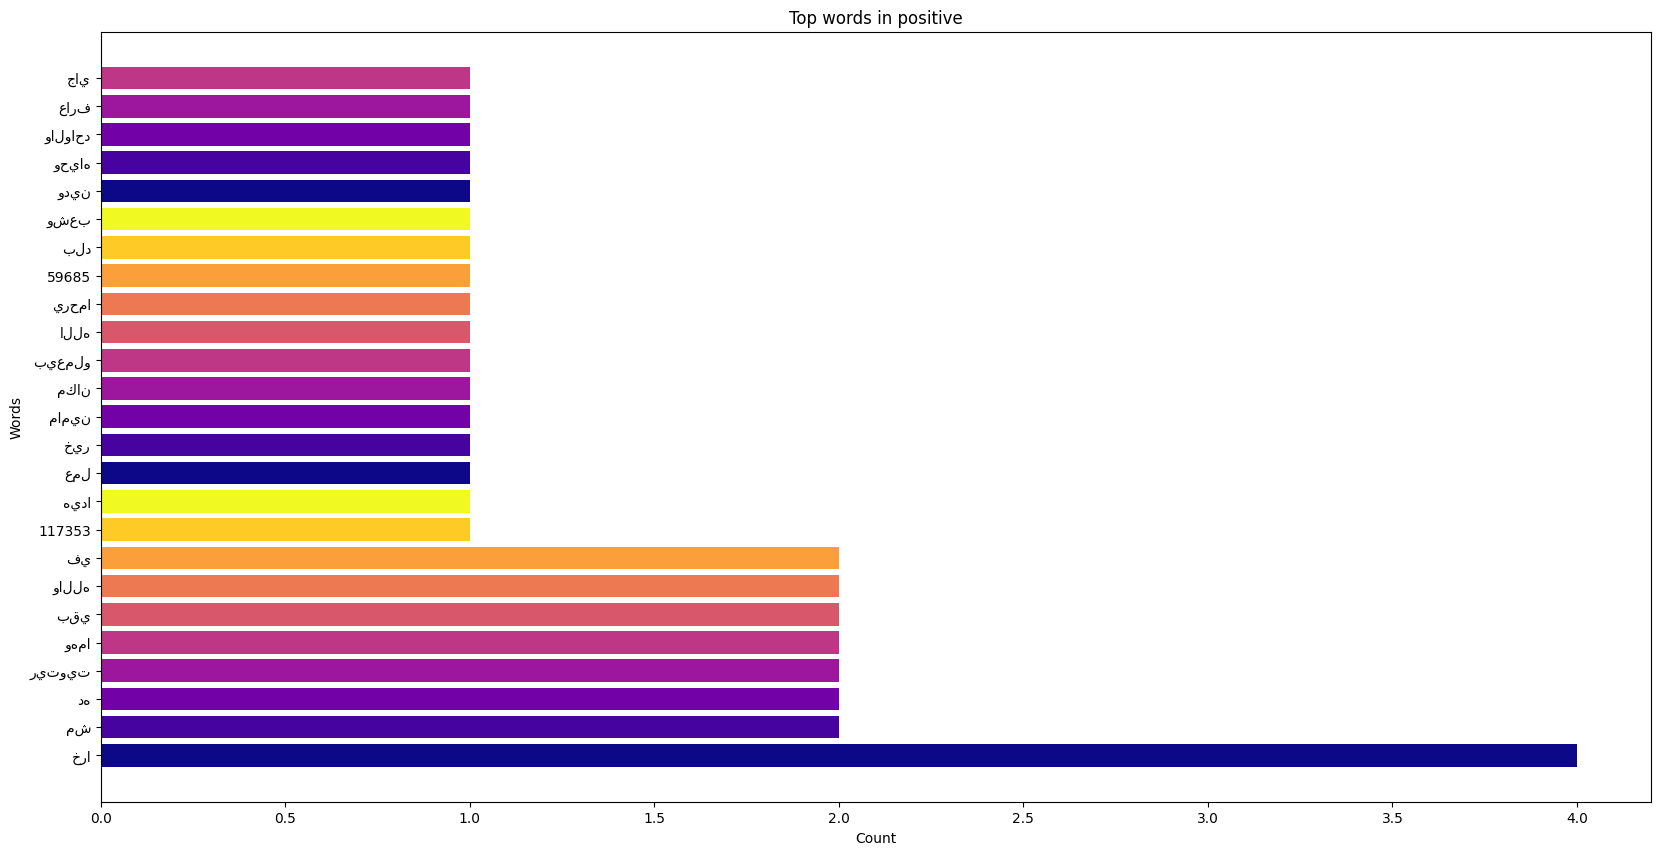

In [89]:
words = []
counts = []
for letter, count in counter.most_common(25):
    words.append(letter)
    counts.append(count)

colors = cm.plasma(np.linspace(0, 1, 10))
plt.rcParams['figure.figsize'] = 20, 10

plt.title('Top words in positive')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


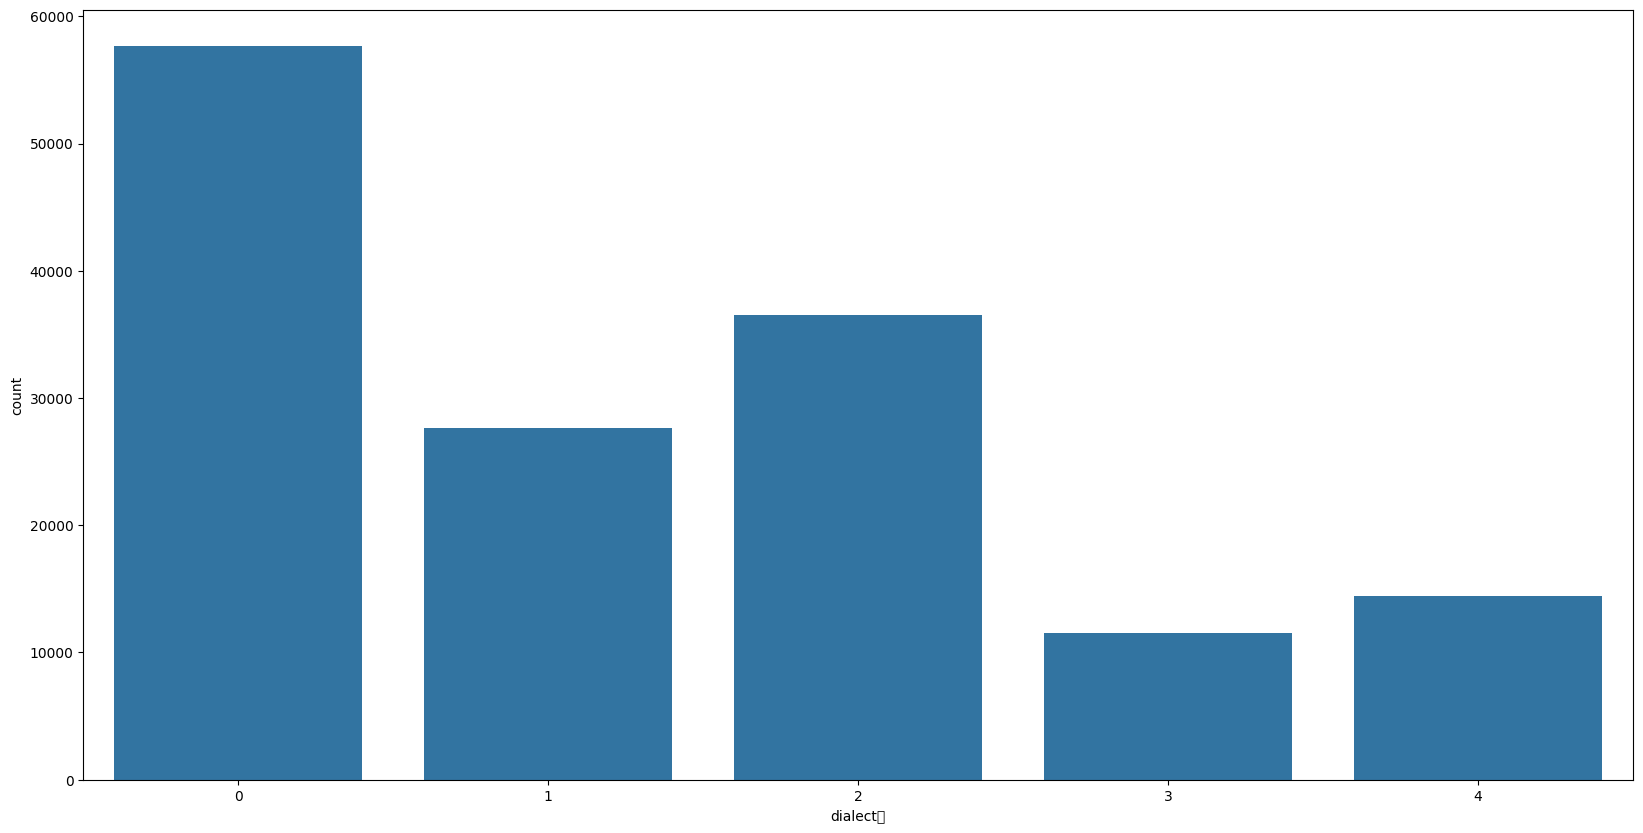

In [86]:
sns.countplot(data= data, x = "dialect\r")
plt.show()